In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

from fuzzywuzzy import process


# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "correct_return_periods.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path, get_data_paths, setup_root_paths
setup_project_paths(PATH)


#from utils_plotting import plot_time_series, plot_random_monthly_and_yearly_data, plot_feature_histograms, plot_contry_period_map
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
from utils_p_i import calculate_p_i
from utils_P_i import calculate_P_i

#from utils_likelihoods import calculate_likelihood_of_at_least_one_event

from utils_return_periods import calculate_return_periods

#from utils_global_probabilities import calculate_global_probabilities
#from utils_country_probabilities import calculate_all_country_probabilities
#from utils_check_expected_features import check_expected_features    
from utils_date_index import calculate_date_from_index 

#from utils_country_id_csv_to_json import country_id_csv_to_json

from utils_get_country_names_by_ids import get_country_names_by_ids
from utils_get_country_id_by_name import get_country_id_by_name

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
PATH_RAW_VIEWSER, PATH_RAW_EXTERNAL, PATH_PROCESSED, PATH_GENERATED = get_data_paths(PATH)

In [4]:
# # load the data from pkl
# df_monthly = pd.read_pickle(PATH_RAW_VIEWSER / "simon_full_base_01_viewser_df.pkl")
# 
# df_yearly = aggregate_monthly_to_yearly(df_monthly)
# 
# # Feature engineering
# df_monthly = feature_eng_fat_per_100k(df_monthly)
# df_yearly = feature_eng_fat_per_100k(df_yearly)
# 
# # save the data
# df_monthly.to_pickle(PATH_PROCESSED / "df_monthly_new.pkl")  
# df_yearly.to_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [5]:
# load the data
df_monthly = pd.read_pickle(PATH_PROCESSED / "df_monthly_new.pkl")
df_yearly = pd.read_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [10]:
def get_time_period(df):
    
    if 'month_id' in df.columns:
        return 'month_id'
    
    elif 'year_id' in df.columns:
        return 'year_id'
    
    else:
        print(df.columns)
        #raise ValueError('Time period not found')

In [30]:
def plot_features_grid(df, feature, period_range, period_specific_min_max=False):
    """
    
    """
    
    features_list = [feature, f'{feature}_p_i', f'{feature}_P_i', f'{feature}_e_i', f'{feature}_E_i']

    # check that the feature is present in the df
    if not all(feature in df.columns for feature in features_list):
        raise ValueError('Feature not found in df')
    
    # that the feature is not empty
    if df[feature].isnull().all():
        raise ValueError(f'{feature} is empty')
    
    #check that the features have more than one unique value
    if not all(df[feature].nunique() > 1 for feature in features_list):
        raise ValueError('Feature has less than 2 unique values')

    fig, axs = plt.subplots(len(period_range), len(features_list), figsize=(25, 5 * len(period_range)))

    time_peirod = get_time_period(df)

    if time_peirod == 'month_id':
        # check that the range is between 100 and 600 or raise an error
        min_month_id = df['month_id'].min()
        max_month_id = df['month_id'].max()
        if not all(min_month_id <= period <= max_month_id for period in period_range):
            raise ValueError(f'Monthly time period: Period range should be between {min_month_id} and {max_month_id}')
    elif time_peirod == 'year_id':
        # check that the range is between 1980 and 2020 or raise an error'
        min_year_id = df['year_id'].min()
        max_year_id = df['year_id'].max()
        if not all(min_year_id <= period <= max_year_id for period in period_range):
            raise ValueError(f'Yearly time period: Period range should be between {min_year_id} and {max_year_id}')

    for row_idx, period in enumerate(period_range):

        for col_idx, feature_name in enumerate(features_list):

            # Determine colormap and value range
            if 'P_i' in feature_name or 'p_i' in feature_name:
                cmap = 'rainbow_r'
                vmin = 0
                vmax = 1
            else:
                cmap = 'rainbow'

                if period_specific_min_max:
              
                    # alt where the min and max are period specific
                    vmin = df[df[time_peirod] == period][feature_name].min()
                    vmax = df[df[time_peirod] == period][feature_name].max()

                else:
                    # alt where the min and max are global
                    vmin = df[feature_name].min()
                    vmax = df[feature_name].max()

            # Extract the data for the specific month_id
            period_data = df[df[time_peirod] == period]

            # Calculate the grid size based on min and max row and col values
            min_row = int(period_data['row'].min())
            max_row = int(period_data['row'].max())
            min_col = int(period_data['col'].min())
            max_col = int(period_data['col'].max())

            # Create the grid with adjusted size
            grid_rows = max_row - min_row + 1
            grid_cols = max_col - min_col + 1
            grid = np.full((grid_rows, grid_cols), np.nan)

            # Fill the grid with the feature_name values, adjusting for min_row and min_col
            for _, row in period_data.iterrows():
                grid[int(row['row']) - min_row, int(row['col']) - min_col] = row[feature_name]

            # Plot with imshow
            cax = axs[row_idx, col_idx].imshow(grid, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', aspect='auto', interpolation='none')
            fig.colorbar(cax, ax=axs[row_idx, col_idx], orientation='vertical', label=feature_name)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_features_grid(new_df, 'some_feature')

In [6]:
def update_df_with_probabilities_and_return_periods_pretest(df, feature):

    # check that it is a pandas dataframe
    if not isinstance(df, pd.DataFrame):
        raise ValueError('df is not a pandas dataframe')

    # check the df is not empty
    if df.empty:
        raise ValueError('DataFrame is empty')

    # checkt that the time period is present
    time_period_column = ['month_id', 'year_id']
    
    if time_period_column[0] not in df.columns and time_period_column[1] not in df.columns:
        raise ValueError('Time period not found')

    # check that the other relevant columns are present
    relevant_columns = ['pg_id', 'c_id', 'row', 'col', feature]
    for column in relevant_columns:
        if column not in df.columns:
            raise ValueError(f'{column} not found in df')

    # check that the feature is not empty
    if df[feature].isnull().all():
        raise ValueError(f'{feature} is empty')

    # check that the feature is not negative
    if (df[feature] < 0).any():
        raise ValueError(f'{feature} contains negative values')

    # check for null, inf and nan
    if df.isnull().values.any():
        raise ValueError('DataFrame contains NaN values')

    if np.isinf(df.values).any():
        raise ValueError('DataFrame contains infinite values')

    return True

    

def check_region_id(region_id_type, region_id, df):

    """
    
    """

    if region_id_type == 'pg_ids':
        # chekc that the region_id is present in the df pg_ids
        if region_id not in df['pg_id'].unique():
            raise ValueError(f'{region_id} not found in pg_id column')
        
    elif region_id_type == 'c_ids':
        # chekc that the region_id is present in the df c_ids
        if region_id not in df['c_id'].unique():
            raise ValueError(f'{region_id} not found in c_id column')
        
    elif region_id_type == 'global':
        pass

    else:
        raise ValueError(f'{region_id_type} not recognized')

    return True

def subset_regional_df(df, region_id_type, region_id):

    """

    """

    if region_id_type == 'pg_ids':
        sub_df = df[df['pg_id'] == region_id].copy()
        
    elif region_id_type == 'c_ids':
        sub_df = df[df['c_id'] == region_id].copy()
        
    elif region_id_type == 'global':
        sub_df = df.copy()

    else:
        raise ValueError(f'{region_id_type} not recognized')
    
    return sub_df

def update_df_with_probabilities_and_return_periods(df, feature, region_id_type, region_id):

    """

    """

    update_df_with_probabilities_and_return_periods_pretest(df, feature)
    check_region_id(region_id_type, region_id, df)
    time_period = get_time_period(df)

    # sub set the df according to the region_id_type and region_id - if global, then the whole df is used but we still do this for consistency
    sub_df = subset_regional_df(df, region_id_type, region_id)


    feature_series = sub_df[feature]
    n_cells = sub_df['pg_id'].unique().shape[0] # THIS WOULD ONLT CHANGE IF WE AGGREGATE THE PRIO GRID CELLS

    # you should check here if the feature have any values apart from 0, if not, you should raise a waring and fill it appropre values for the new columns
    if (feature_series == 0).all():
        print(f'WARINING: {feature} in {region_id_type} {region_id} contains only 0 values - filling the new columns with appropriate values, i.e. 1 for p_i, 1 for P_i, 1 for e_i, 1 for E_i')
        value_counts = feature_series.value_counts().sort_index(ascending=False)
        df_probabilities = pd.DataFrame({'value_count' : value_counts, 'value': value_counts.index}).reset_index(drop=True) # what happens internally in calculate_p_i as well
        df_probabilities[f'p_i'] = 1
        df_probabilities[f'P_i'] = 1
        df_probabilities[f'e_i'] = 1
        df_probabilities[f'E_i'] = 1

    else:
        print(f'Calculating probabilities and return periods for {feature} in {region_id_type} {region_id}')
        # calculate the probabilities and return periods
        df_probabilities = calculate_p_i(feature_series)
        df_probabilities = calculate_P_i(df_probabilities, n_cells)
        df_probabilities = calculate_return_periods(df_probabilities)

    # rename the calculated columns to match the original df feature
    df_probabilities.rename(columns={'value': feature, 'value_count' : f'{feature}_value_count', 'p_i' : f"{feature}_p_i", 'P_i' : f"{feature}_P_i", 'e_i' : f"{feature}_e_i", 'E_i' : f"{feature}_E_i"}, inplace=True)

 
    # Merge
    merged_df = pd.merge(sub_df, df_probabilities, on=[feature], how='left')

    # delete the sub_df and df_probabilities
    del sub_df
    del df_probabilities

    # check for null, inf and nan
    if merged_df.isnull().values.any():
        raise ValueError('DataFrame contains NaN values')

    return merged_df


In [7]:
df_yearly.columns

Index(['pg_id', 'year_id', 'c_id', 'col', 'row', 'sb_best', 'ns_best',
       'os_best', 'pop_gpw_sum', 'total_best', 'fatalities_per_100k',
       'sb_per_100k', 'ns_per_100k', 'os_per_100k'],
      dtype='object')

In [8]:
get_country_names_by_ids([119])

{119: 'Oman'}

In [9]:
# okay lets try and loop over all the countries and then merge the dataframes. Yearly data only for now
feature = 'fatalities_per_100k'

unique_country_ids = df_yearly['c_id'].unique()

# create an empty dataframe to store the results
df_yearly_global_country_level = pd.DataFrame()

for i, country_id in enumerate(unique_country_ids):
    print(f'Processing country_id: {country_id} {i}/{len(unique_country_ids)}') #, country_name: {get_country_names_by_ids([country_id])}')

    try:
        new_df_yearly_country = update_df_with_probabilities_and_return_periods(df_yearly, feature, 'c_ids', country_id)
        df_yearly_global_country_level = pd.concat([df_yearly_global_country_level, new_df_yearly_country])

    except Exception as e:
        print(f'Error with {country_id}: {e}') #, country_name: {get_country_names_by_ids([country_id])}. Skipping...')


Processing country_id: 192 0/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 192
Processing country_id: 163 1/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 163
Processing country_id: 160 2/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 160
Processing country_id: 170 3/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 170
Processing country_id: 164 4/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 164
Processing country_id: 154 5/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 154
Processing country_id: 162 6/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 162
Processing country_id: 172 7/85
Calculating probabilities and return periods for fatalities_per_100k in c_ids 172
Processing country_id: 158 8/85
Calculating probabilities and return periods for fatalit

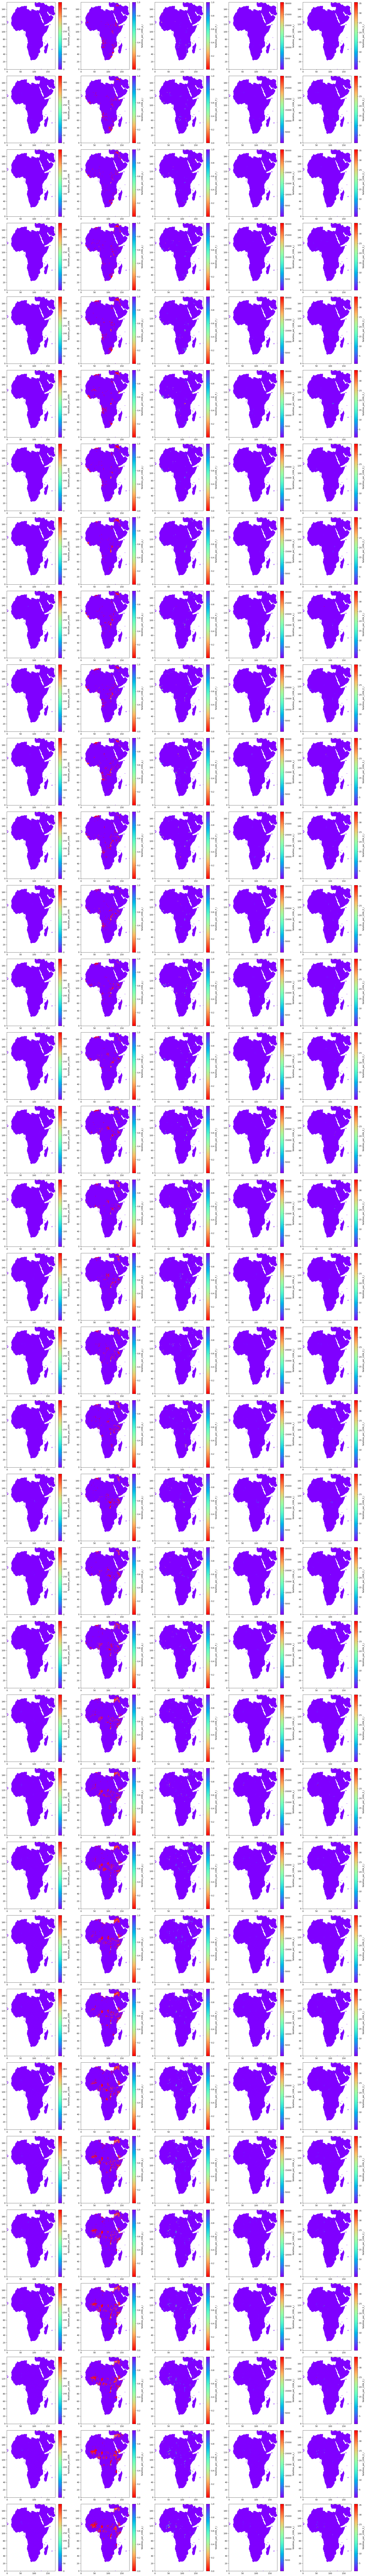

In [13]:
all_years = df_yearly_global_country_level['year_id'].unique()
plot_features_grid(df_yearly_global_country_level, feature, all_years)


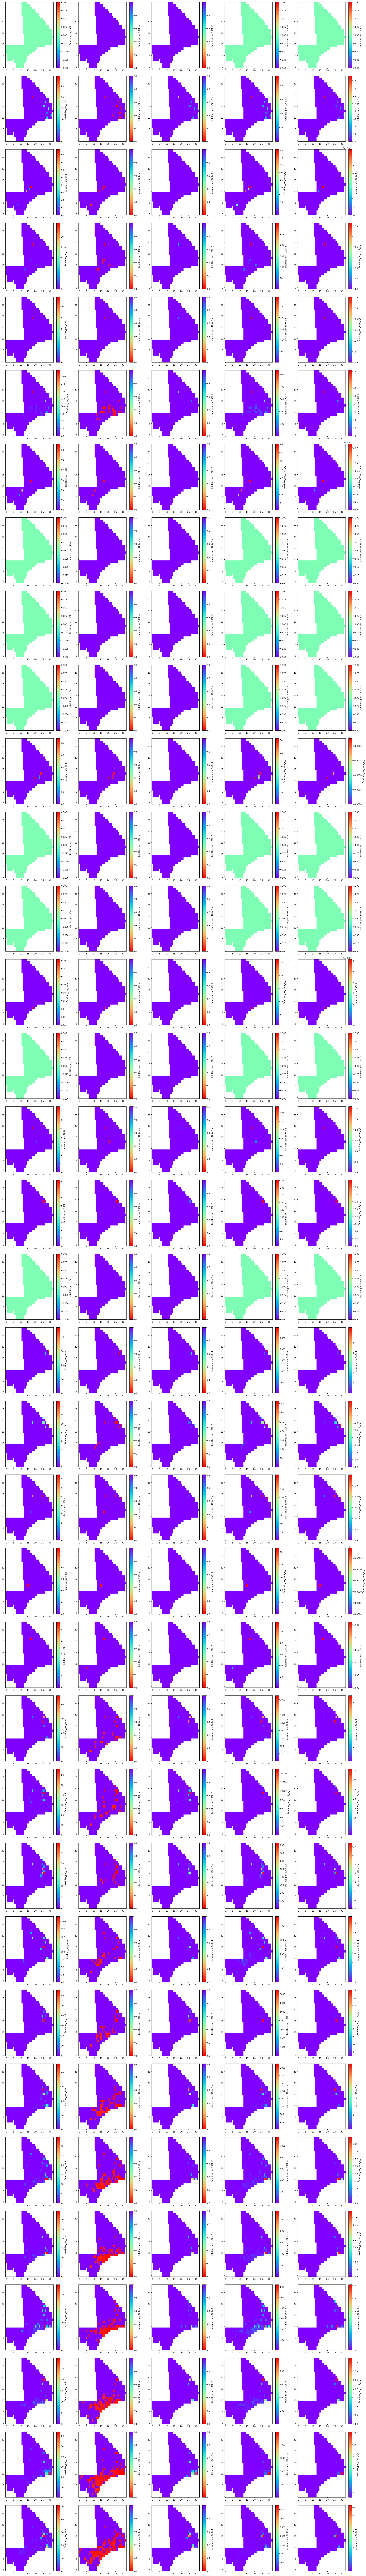

In [31]:
# plot one country
country_id = 50
feature = 'fatalities_per_100k'
all_years = df_yearly_global_country_level['year_id'].unique()

plot_features_grid(df_yearly_global_country_level[df_yearly_global_country_level['c_id'] == country_id], feature, all_years)

In [ ]:
new_df_monthly = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, region_id)
new_df_yearly = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, region_id)

In [ ]:
new_df_yearly.describe()

In [ ]:
# try with a country
country_name = 'Mali'
country_id = get_country_id_by_name(country_name)
print(country_id)

country_id = 50
region_id_type = 'c_ids' # pg_ids, c_ids, or global

new_df_monthly_mali = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, country_id)
new_df_yearly_mali = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, country_id)

new_df_monthly_mali.describe()
new_df_yearly_mali.describe()

In [ ]:
new_df_monthly_mali['month_id'].max()

In [ ]:
# check wivh month id have the event with the higsest E_i
new_df_monthly_mali[new_df_monthly_mali['fatalities_per_100k_E_i'] == new_df_monthly_mali['fatalities_per_100k_E_i'].max()]['month_id']

In [ ]:
new_df_yearly_mali

In [ ]:
plot_features_grid(new_df_yearly_mali, feature, period_range = np.arange(2020, 2024))

In [ ]:
# try with rwanda
country_name = 'Rwanda'
country_id = get_country_id_by_name(country_name)
print(country_id)
country_id = 156

new_df_monthly_rwanda = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, country_id)
new_df_yearly_rwanda = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, country_id)


In [ ]:
plot_features_grid(new_df_yearly_rwanda, feature, period_range = np.arange(1992, 1996))

In [ ]:
# what months see the highest E_i
high_month = new_df_monthly_rwanda[new_df_monthly_rwanda['fatalities_per_100k_E_i'] == new_df_monthly_rwanda['fatalities_per_100k_E_i'].max()]['month_id'].values[0]
print(high_month)
print(calculate_date_from_index(high_month))

#lest try ranwda with the monthly data
plot_features_grid(new_df_monthly_rwanda, feature, period_range = np.arange(high_month-5, high_month+5))

In [22]:
# try "global" yearly 1992-1996
region_id_type = 'global'
region_id = None

new_df_monthly_global = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, region_id)
new_df_yearly_global = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, region_id)

plot_features_grid(new_df_yearly_global, feature, period_range = np.arange(1991, 2024))

In [ ]:
get_country_names_by_ids([50])

In [ ]:
# okay lets try and loop over all the countries and then merge the dataframes. Yearly data only for now

unique_country_ids = df_yearly['c_id'].unique()

# create an empty dataframe to store the results
df_yearly_global_country_level = pd.DataFrame()

for country_id in unique_country_ids:
    print(f'Processing country_id: {country_id}') #, country_name: {get_country_names_by_ids([country_id])}')

    try:
        new_df_yearly_country = update_df_with_probabilities_and_return_periods(df_yearly, feature, 'c_ids', country_id)
        df_yearly_global_country_level = pd.concat([df_yearly_global_country_level, new_df_yearly_country])

    except Exception as e:
        print(f'Error with {country_id}: {e}') #, country_name: {get_country_names_by_ids([country_id])}. Skipping...')



In [ ]:
df_yearly_global_country_level.describe()

In [ ]:
# now plot all the years for the whole world
plot_features_grid(df_yearly_global_country_level, feature, period_range = np.arange(1991, 2024))

In [ ]:
get_country_id_by_name('Malawi')

In [ ]:
df_yearly[df_yearly['c_id'] == 161].describe()